In [4]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from utils.paths import SetupPaths
import matplotlib.patches as  mpatches
from utils.get_summary_data import compile_summary
from utils.vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

In [5]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in"})


In [6]:
# defining equivalent redshifts
zs = {"z":np.array([0,1,2,3,4]), 
      "zill":np.array([135,85,68,60,56]), 
      "ztng":np.array([99,50,33,25,22])}

# defining color palette for plotting
palette = {"Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC"}


# Initialization 

In [7]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask

In [112]:

def separations(size, snap):

    sim = "TNG"
    snapshot = snap

    pair_path = f"{sim}_{snapshot}_10_matched.hdf5"
    pair_data = h5py.File(f"{paths.path_data}matched/Vicente/{pair_path}", "r")
    
    z = pair_data['Header'].attrs['Redshift']

    pairs_h = pair_data["paired"]["hydro"]
    pairs_d = pair_data["paired"]["dark match"]

    pri_stell = np.array(pairs_h["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs_h["Sub2 Stellar Mass"])
    seps = np.array(pairs_h["Separation"]) 

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(np.array(pairs_h["Group Mass"]), size)
    pair_sepcut = seps > 10
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_group & pair_sepcut

    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors

    majors_h = np.array(pairs_h["Separation"])[major_mask]
    minors_h = np.array(pairs_h["Separation"])[minor_mask]

    hydro_dict = {"major":majors_h, "minor":minors_h}
    
    majors_d = np.array(pairs_d["Separation"])[major_mask]
    minors_d = np.array(pairs_d["Separation"])[minor_mask]
    
    dark_dict = {"major":majors_d, "minor":minors_d}

    return hydro_dict, dark_dict, z


In [9]:
class EmptyFile(Exception): pass
class SkipRedshift(Exception): pass


def sep_eval( size, redshiftcutoff=True):    
    # Sim = TNG
    snapshots = np.arange(0,100,1)
    snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
    redcutoff = 4
        
    redshifts = []
    median_hmaj, quart_hmaj = [], []
    median_dmaj, quart_dmaj = [], []
    median_hmin, quart_hmin = [], []
    median_dmin, quart_dmin = [], []
    
    for snap in snapshots:  
        try:
            seps_h, seps_d, z = separations(size, snap)
            
            if redshiftcutoff & ( z > redcutoff) :
                raise SkipRedshift
                
            redshifts.append(z)
            
            median_hmaj.append(np.median(seps_h["major"]))
            median_hmin.append(np.median(seps_h["minor"]))
            median_dmaj.append(np.median(seps_d["major"]))
            median_dmin.append(np.median(seps_d["minor"]))
            
            lower, upper = 16, 84

            quart_hmaj.append(np.percentile( seps_h["major"], [lower,upper]))
            quart_hmin.append(np.percentile( seps_h["minor"], [lower,upper]))
            quart_dmaj.append(np.percentile( seps_d["major"], [lower,upper]))
            quart_dmin.append(np.percentile( seps_d["minor"], [lower,upper]))
            
            
        except EmptyFile:
#              print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
#              print(f"skipping {snap}, redshift out of range")
            continue
                
    count_dictionary = {
            "z": np.array(redshifts),
            "Median H-Major": np.array(median_hmaj),
            "Median H-Minor": np.array(median_hmin),
            "Median D-Major": np.array(median_dmaj),
            "Median D-Minor": np.array(median_dmin),
            "Quarts H-Major": np.array(quart_hmaj),
            "Quarts H-Minor": np.array(quart_hmin),
            "Quarts D-Major": np.array(quart_dmaj),
            "Quarts D-Minor": np.array(quart_dmin)}
            
    return count_dictionary

In [20]:
def get_key(sim, phys, size, key, sepcut, errorprint=False, redshiftcutoff=True):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts = []  
    med_pairs, med_major, med_minor = [], [], []
    quart_pairs, quart_major, quart_minor = [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_10.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
            pair = pair_data["pairs"][phys]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            keydat = np.array(pair[key])
            
            # subset masks for unpaired
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)

            # defining combined masks 
            pair_mask = pair_pri & pair_group & pair_lowsep
        
            if sepcut == "low":
                sep_mask = seps < 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
            elif sepcut == "high":
                sep_mask = seps > 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
                               
            pair_per_real = []
            major_per_real = []
            minor_per_real = []
                
            realizations = np.unique( pairReals )

            for real in realizations:
                pair_real = pairReals == real

                pair_mask_real = pair_mask & pair_real & (majors | minors)
                major_mask_real = pair_mask_real & majors
                minor_mask_real = pair_mask_real & minors

                pair_xx = np.median( keydat[pair_mask_real] )
                major_xx = np.median( keydat[major_mask_real] )
                minor_xx = np.median( keydat[minor_mask_real] )

                pair_per_real.append( pair_xx )
                major_per_real.append( major_xx )
                minor_per_real.append( minor_xx )

            med_pairs_snap = np.median(pair_per_real)
            med_major_snap = np.median(major_per_real)
            med_minor_snap = np.median(minor_per_real)
            quart_pairs_snap = np.percentile( pair_per_real,[16,84] ) 
            quart_major_snap = np.percentile( major_per_real,[16,84] ) 
            quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 
                
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )

            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor)}
    
    return sep_dictionary

def get_key_snap(phys, size, key, z):
    zloc = np.where( zs['z'] == z)[0]
    sim = "TNG"
    snapshot = zs['ztng'][zloc][0] 

    pair_path = f"{sim}_{snapshot}_10.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["pairs"][phys]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    seps = np.array(pairs["Separation"]) 

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(np.array(pairs["Group Mass"]), size)
    pair_sepcut = seps > 10
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_group & pair_sepcut

    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors

    majors = np.array(pairs[key])[major_mask]
    minors = np.array(pairs[key])[minor_mask]

    key_dict = {"major":majors, "minor":minors}
    

    return key_dict


def get_key_matched(sim, phys, size, key, sepcut, errorprint=False, redshiftcutoff=True):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts = []  
    med_pairs, med_major, med_minor = [], [], []
    quart_pairs, quart_major, quart_minor = [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_10.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
            pair = pair_data["pairs"][phys]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            keydat = np.array(pair[key])
            
            # subset masks for unpaired
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)

            # defining combined masks 
            pair_mask = pair_pri & pair_group & pair_lowsep
        
            if sepcut == "low":
                sep_mask = seps < 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
            elif sepcut == "high":
                sep_mask = seps > 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
                               
            pair_per_real = []
            major_per_real = []
            minor_per_real = []
                
            realizations = np.unique( pairReals )

            for real in realizations:
                pair_real = pairReals == real

                pair_mask_real = pair_mask & pair_real & (majors | minors)
                major_mask_real = pair_mask_real & majors
                minor_mask_real = pair_mask_real & minors

                pair_xx = np.median( keydat[pair_mask_real] )
                major_xx = np.median( keydat[major_mask_real] )
                minor_xx = np.median( keydat[minor_mask_real] )

                pair_per_real.append( pair_xx )
                major_per_real.append( major_xx )
                minor_per_real.append( minor_xx )

            med_pairs_snap = np.median(pair_per_real)
            med_major_snap = np.median(major_per_real)
            med_minor_snap = np.median(minor_per_real)
            quart_pairs_snap = np.percentile( pair_per_real,[16,84] ) 
            quart_major_snap = np.percentile( major_per_real,[16,84] ) 
            quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 
                
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )

            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor)}
    
    return sep_dictionary


# Separation: hydro vs. dark match

## dwarf

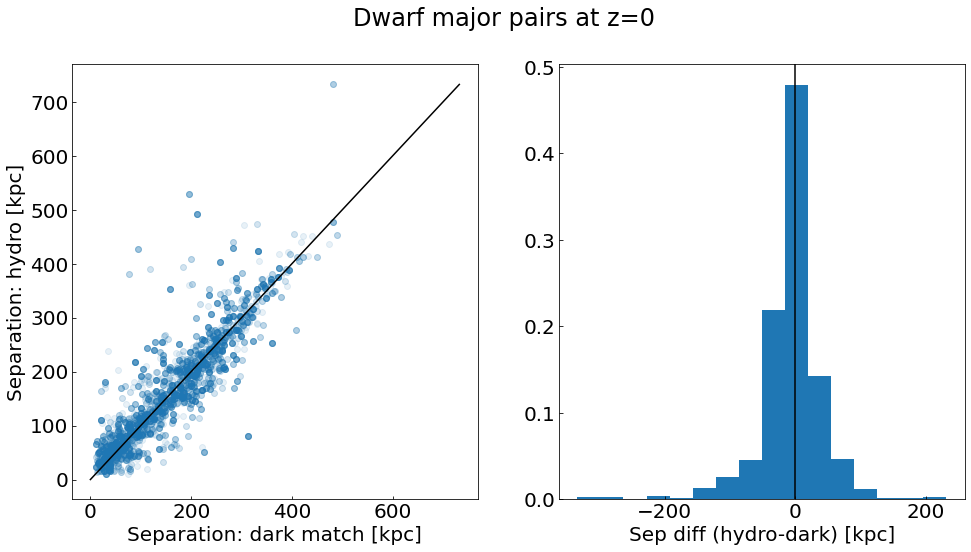

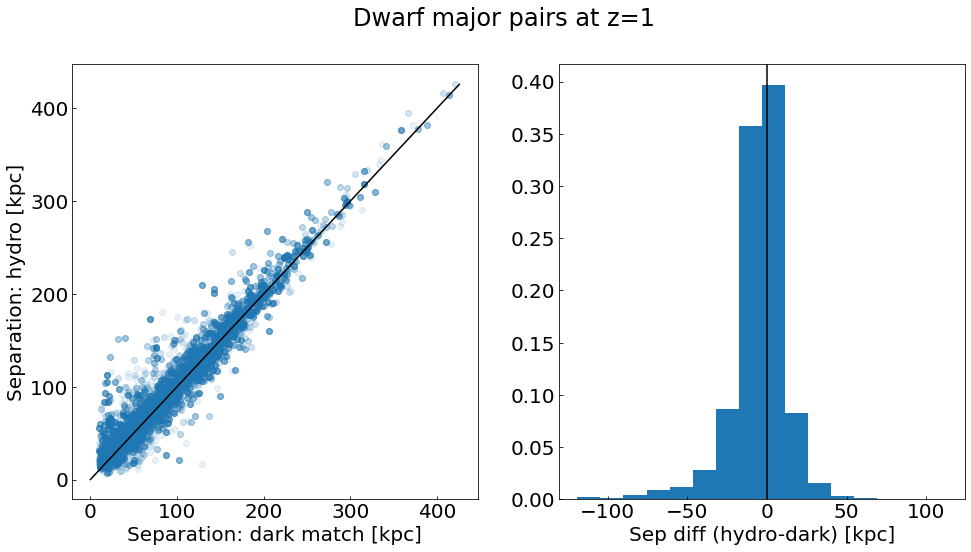

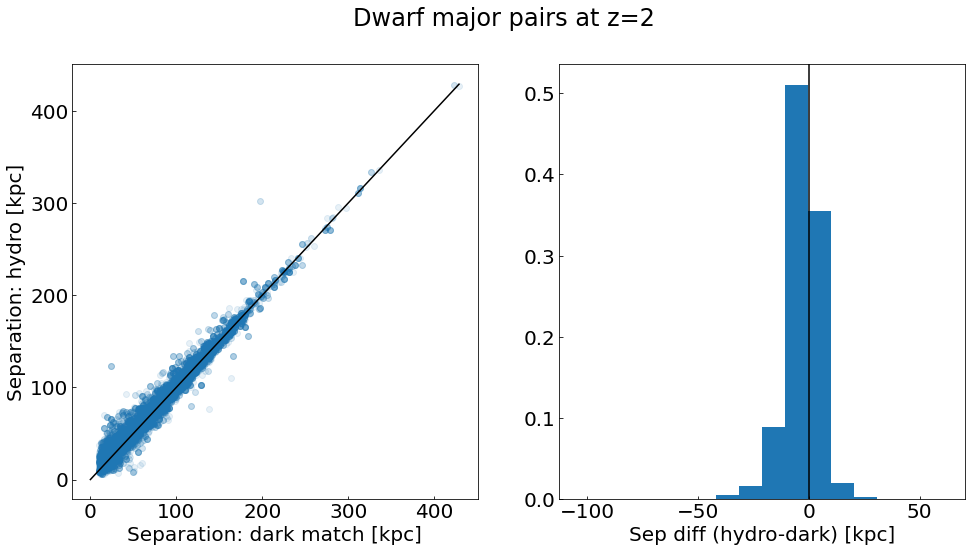

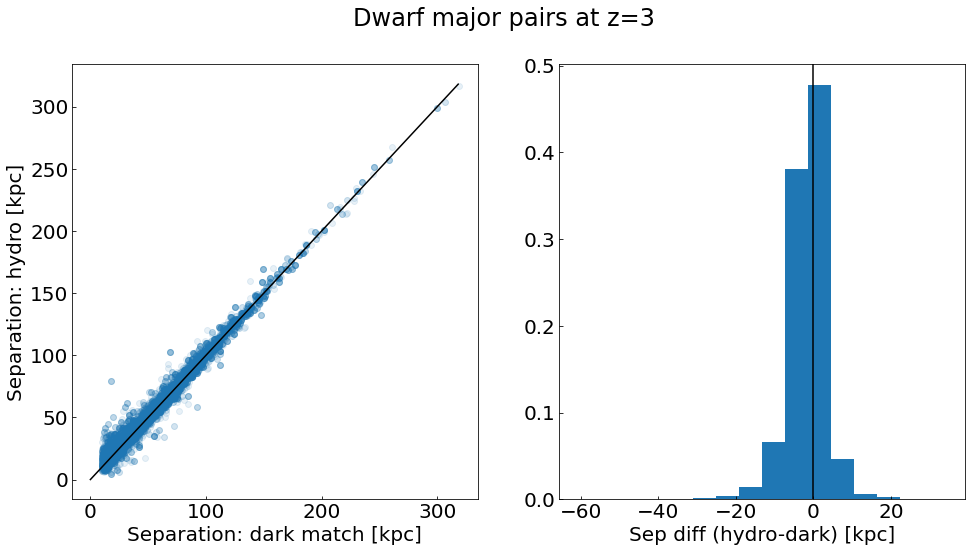

In [44]:
pairtype = "major"
for z in [0,1,2,3]:
    fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=False)
    plt.subplots_adjust(wspace=0.2)

    pairtype = "major"
    seps_h, seps_d = separations_z( "dwarf", z)
    maxxsep = max(max(seps_h[pairtype]),max(seps_d[pairtype]))
    lin = np.arange(0,maxxsep)

    ax[0].scatter(seps_h[pairtype], seps_d[pairtype],alpha=0.1)
    ax[0].plot(lin, lin, color="black")
    ax[1].hist(seps_h[pairtype]-seps_d[pairtype],weights = np.ones(len(seps_h[pairtype]))/len(seps_h[pairtype]))
    ax[1].axvline(0,color='black')

    ax[0].set_xlabel("Separation: dark match [kpc]")
    ax[0].set_ylabel("Separation: hydro [kpc]")
    ax[1].set_xlabel("Sep diff (hydro-dark) [kpc]")
    
#     pairtype = "minor"
#     maxxsep = max(max(seps_h[pairtype]),max(seps_d[pairtype]))
#     lin = np.arange(0,maxxsep)

#     ax[0].scatter(seps_h[pairtype], seps_d[pairtype],alpha=0.1)
#     ax[1].hist(seps_h[pairtype]-seps_d[pairtype],weights = np.ones(len(seps_h[pairtype]))/len(seps_h[pairtype]),alpha=0.5)

    # ax[0].legend(loc="upper right")
    # ax[0].set_ylabel("Relative velocity [km/s]")
    # ax[0].set_xlabel("Separation [kpc]")
    # ax[1].set_xlabel("Separation [kpc]")
    fig.suptitle(f"Dwarf major pairs at z={z}")

    plt.show()


## massive

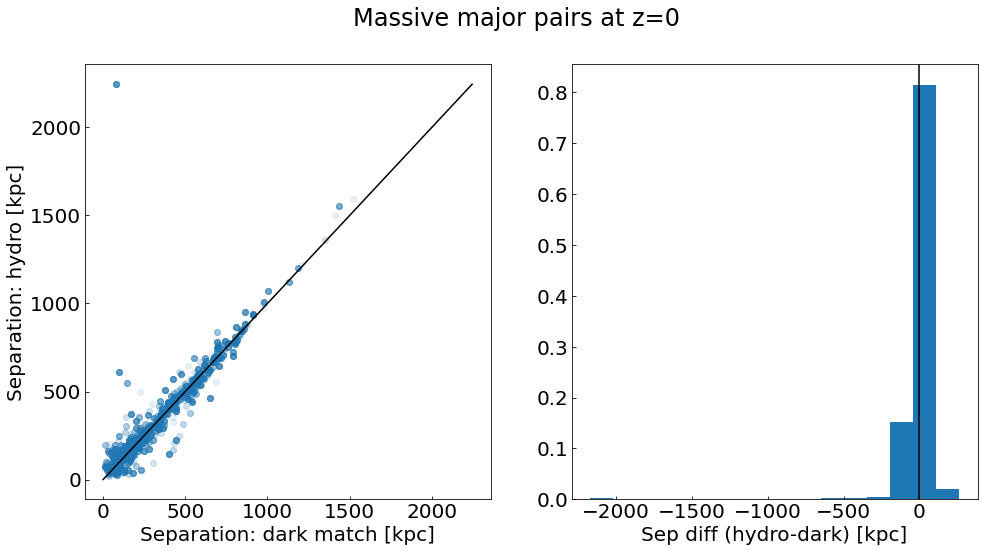

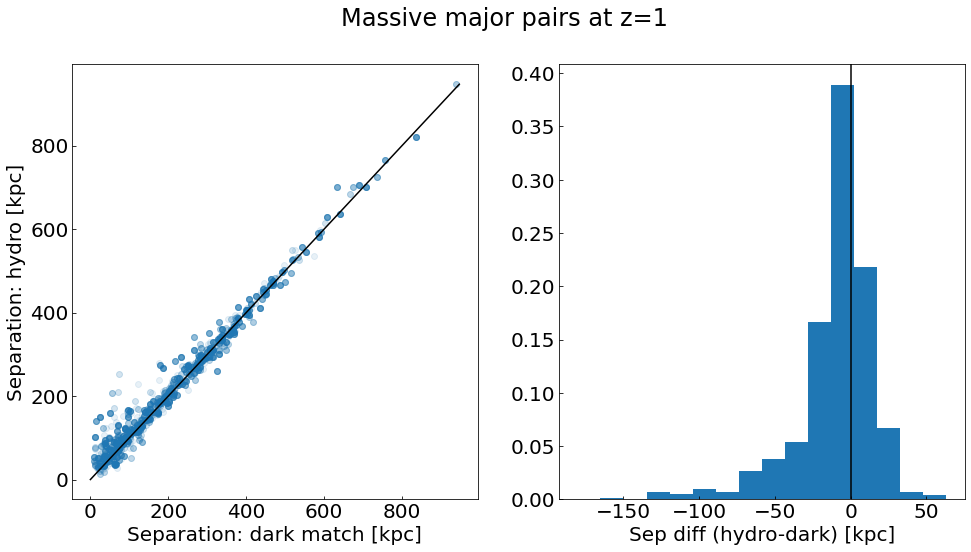

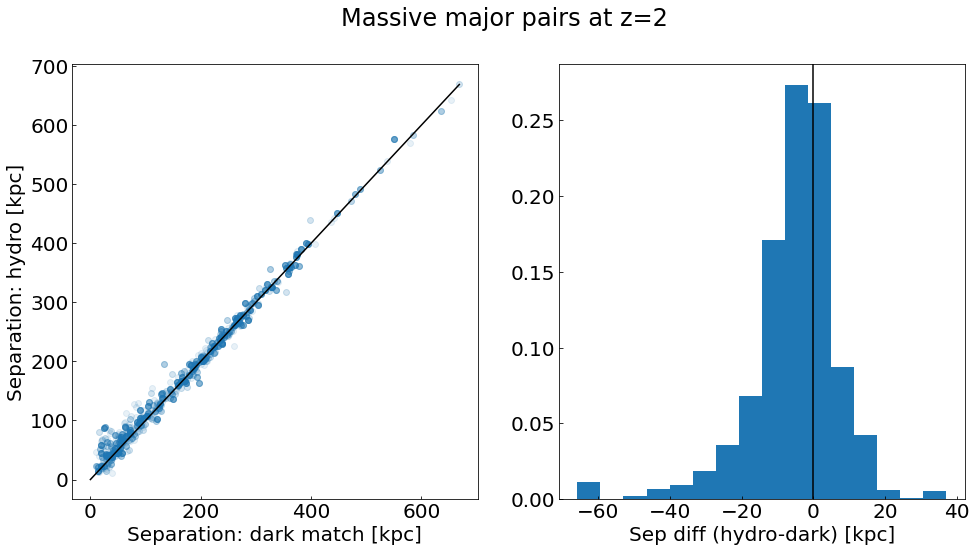

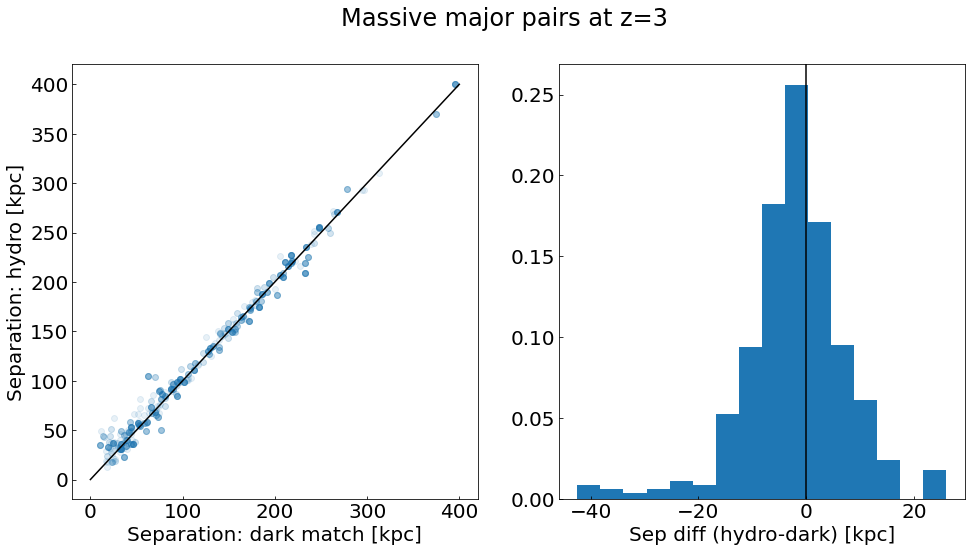

In [46]:
pairtype = "major"
for z in [0,1,2,3]:
    fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=False)
    plt.subplots_adjust(wspace=0.2)

    pairtype = "major"
    seps_h, seps_d = separations( "massive", z)
    maxxsep = max(max(seps_h[pairtype]),max(seps_d[pairtype]))
    lin = np.arange(0,maxxsep)

    ax[0].scatter(seps_h[pairtype], seps_d[pairtype],alpha=0.1)
    ax[0].plot(lin, lin, color="black")
    ax[1].hist(seps_h[pairtype]-seps_d[pairtype],weights = np.ones(len(seps_h[pairtype]))/len(seps_h[pairtype]))
    ax[1].axvline(0,color='black')

    ax[0].set_xlabel("Separation: dark match [kpc]")
    ax[0].set_ylabel("Separation: hydro [kpc]")
    ax[1].set_xlabel("Sep diff (hydro-dark) [kpc]")
    
#     pairtype = "minor"
#     maxxsep = max(max(seps_h[pairtype]),max(seps_d[pairtype]))
#     lin = np.arange(0,maxxsep)

#     ax[0].scatter(seps_h[pairtype], seps_d[pairtype],alpha=0.1)
#     ax[1].hist(seps_h[pairtype]-seps_d[pairtype],weights = np.ones(len(seps_h[pairtype]))/len(seps_h[pairtype]),alpha=0.5)

    # ax[0].legend(loc="upper right")
    # ax[0].set_ylabel("Relative velocity [km/s]")
    # ax[0].set_xlabel("Separation [kpc]")
    # ax[1].set_xlabel("Separation [kpc]")
    fig.suptitle(f"Massive major pairs at z={z}")

    plt.show()


# Distributions


In [ ]:
def separations_z(size, z):
    
    zloc = np.where( zs['z'] == z)[0]
    sim = "TNG"
    snapshot = zs['ztng'][zloc][0] 


    pair_path = f"{sim}_{snapshot}_10_matched.hdf5"
    pair_data = h5py.File(f"{paths.path_data}matched/Vicente/{pair_path}", "r")

    pairs_h = pair_data["paired"]["hydro"]
    pairs_d = pair_data["paired"]["dark match"]

    pri_stell = np.array(pairs_h["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs_h["Sub2 Stellar Mass"])
    seps = np.array(pairs_h["Separation"]) 

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(np.array(pairs_h["Group Mass"]), size)
    pair_sepcut = seps > 10
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_group & pair_sepcut

    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors

    majors_h = np.array(pairs_h["Separation"])[major_mask]
    minors_h = np.array(pairs_h["Separation"])[minor_mask]

    hydro_dict = {"major":majors_h, "minor":minors_h}
    
    majors_d = np.array(pairs_d["Separation"])[major_mask]
    minors_d = np.array(pairs_d["Separation"])[minor_mask]
    
    dark_dict = {"major":majors_d, "minor":minors_d}

    return hydro_dict, dark_dict

def velocities_z(size, z):
    
    zloc = np.where( zs['z'] == z)[0]
    sim = "TNG"
    snapshot = zs['ztng'][zloc][0] 


    pair_path = f"{sim}_{snapshot}_10_matched.hdf5"
    pair_data = h5py.File(f"{paths.path_data}matched/Vicente/{pair_path}", "r")

    pairs_h = pair_data["paired"]["hydro"]
    pairs_d = pair_data["paired"]["dark match"]

    pri_stell = np.array(pairs_h["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs_h["Sub2 Stellar Mass"])
    seps = np.array(pairs_h["Separation"]) 

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(np.array(pairs_h["Group Mass"]), size)
    pair_sepcut = seps > 10
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_group & pair_sepcut

    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors

    majors_h = np.array(pairs_h["RelVel"])[major_mask]
    minors_h = np.array(pairs_h["RelVel"])[minor_mask]

    hydro_dict = {"major":majors_h, "minor":minors_h}
    
    majors_d = np.array(pairs_d["RelVel"])[major_mask]
    minors_d = np.array(pairs_d["RelVel"])[minor_mask]
    
    dark_dict = {"major":majors_d, "minor":minors_d}

    return hydro_dict, dark_dict

def get_key_snap(phys, size, key, z):
    zloc = np.where( zs['z'] == z)[0]
    sim = "TNG"
    snapshot = zs['ztng'][zloc][0] 

    pair_path = f"{sim}_{snapshot}_10.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["pairs"][phys]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    seps = np.array(pairs["Separation"]) 

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(np.array(pairs["Group Mass"]), size)
    pair_sepcut = seps > 10
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_group & pair_sepcut

    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors

    majors = np.array(pairs[key])[major_mask]
    minors = np.array(pairs[key])[minor_mask]

    key_dict = {"major":majors, "minor":minors}
    

    return key_dict

## Separation distribution

### Comparison - dwarf pairs (all: major + minor)

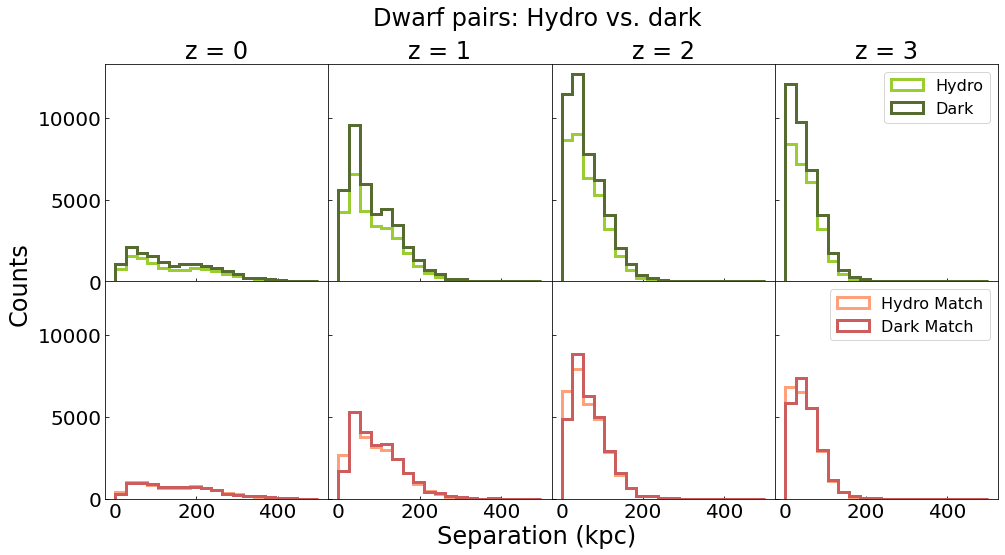

In [102]:
# hydro vs. hydro_matched (all pairs)
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey=True,sharex=False)
plt.subplots_adjust(wspace=0,hspace=0)

for i in range(4):
    dwarf = get_key_snap("hydro", "dwarf", "Separation", i)
    dwarf_dark = get_key_snap("dark", "dwarf", "Separation", i)
    
    dwarf_match, dwarf_dark_match = separations_z("dwarf", i)
    
    dwarf = np.concatenate([dwarf['major'],dwarf['minor']])
    dwarf_match = np.concatenate([dwarf_match['major'],dwarf_match['minor']])
    dwarf_dark = np.concatenate([dwarf_dark['major'],dwarf_dark['minor']])
    dwarf_dark_match = np.concatenate([dwarf_dark_match['major'],dwarf_dark_match['minor']])
        
    bins_d = np.linspace(0,500,20)
    
    ax[0][i].set_title(f"z = {i}")

    # Illustris Major pairs
    ax[0][i].hist(dwarf, bins=bins_d,histtype="step", color="yellowgreen", lw=3, label='Hydro')
    ax[0][i].hist(dwarf_dark, bins=bins_d,histtype="step", color="darkolivegreen", lw=3, label='Dark')
    
    ax[1][i].hist(dwarf_match, bins=bins_d,histtype="step", color="lightsalmon", lw=3, label='Hydro Match')
    ax[1][i].hist(dwarf_dark_match, bins=bins_d,histtype="step", color="indianred", lw=3, label='Dark Match')
    

for xx in [ax[0][3],ax[1][3]]:
    leg = xx.legend(loc='upper right',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig.supxlabel(r"Separation (kpc)",y=0.04)
fig.supylabel("Counts",x=0.040)
fig.suptitle("Dwarf pairs: Hydro vs. dark",y=0.98)

plt.savefig(f"../plots/matched/sep_dist_dwarf_hydrodark.png",bbox_inches='tight',facecolor="white")
plt.show()

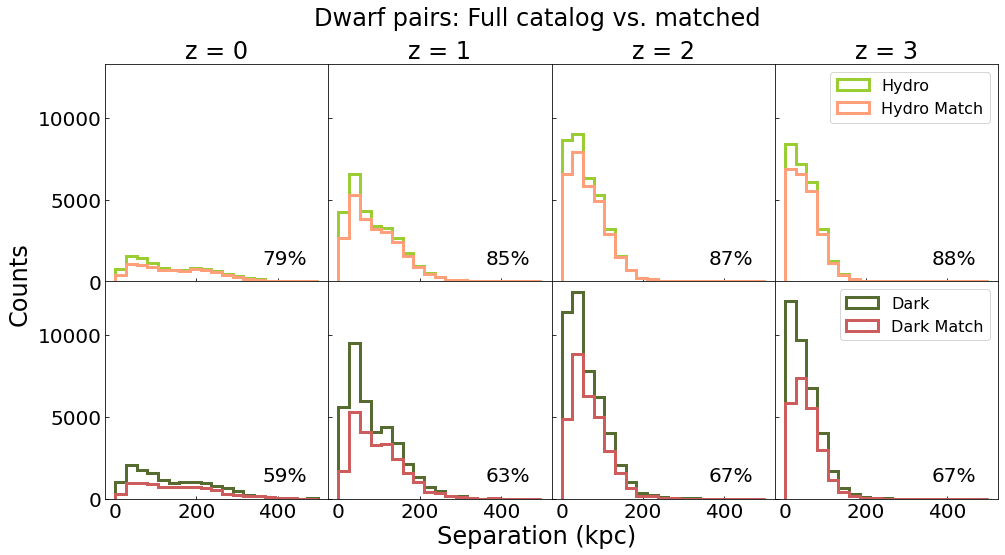

In [103]:
# hydro vs. hydro_matched (all pairs)
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey=True,sharex=False)
plt.subplots_adjust(wspace=0,hspace=0)

hydro_complete = []
dark_complete = []

for i in range(4):
    dwarf = get_key_snap("hydro", "dwarf", "Separation", i)
    dwarf_dark = get_key_snap("dark", "dwarf", "Separation", i)
    
    dwarf_match, dwarf_dark_match = separations_z("dwarf", i)
    
    dwarf = np.concatenate([dwarf['major'],dwarf['minor']])
    dwarf_match = np.concatenate([dwarf_match['major'],dwarf_match['minor']])
    dwarf_dark = np.concatenate([dwarf_dark['major'],dwarf_dark['minor']])
    dwarf_dark_match = np.concatenate([dwarf_dark_match['major'],dwarf_dark_match['minor']])
    
    hydro_complete.append(len(dwarf_match)/len(dwarf))
    dark_complete.append(len(dwarf_dark_match)/len(dwarf_dark))

    bins_d = np.linspace(0,500,20)
    
    ax[0][i].set_title(f"z = {i}")

    ax[0][i].hist(dwarf, bins=bins_d,histtype="step", color="yellowgreen", lw=3, label='Hydro')
    ax[0][i].hist(dwarf_match, bins=bins_d,histtype="step", color="lightsalmon", lw=3, label='Hydro Match')
    
    ax[1][i].hist(dwarf_dark, bins=bins_d,histtype="step", color="darkolivegreen", lw=3, label='Dark')
    ax[1][i].hist(dwarf_dark_match, bins=bins_d,histtype="step", color="indianred", lw=3, label='Dark Match')
    

for xx in [ax[0][3],ax[1][3]]:
    leg = xx.legend(loc='upper right',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    

xmax = ax[0][0].get_xlim()[1]
ymax = ax[0][0].get_ylim()[1]

for i in range(4):
    ax[0][i].text(0.9*xmax,0.15*ymax,f"{hydro_complete[i]*100:.0f}%",va="top",ha="right")
    ax[1][i].text(0.9*xmax,0.15*ymax,f"{dark_complete[i]*100:.0f}%",va="top",ha="right")

    

fig.supxlabel(r"Separation (kpc)",y=0.04)
fig.supylabel("Counts",x=0.040)
fig.suptitle("Dwarf pairs: Full catalog vs. matched",y=0.98)

plt.savefig(f"../plots/matched/sep_dist_dwarf_fullmatch.png",bbox_inches='tight',facecolor="white")
plt.show()

### Comparison - massive pairs (all: major + minor)

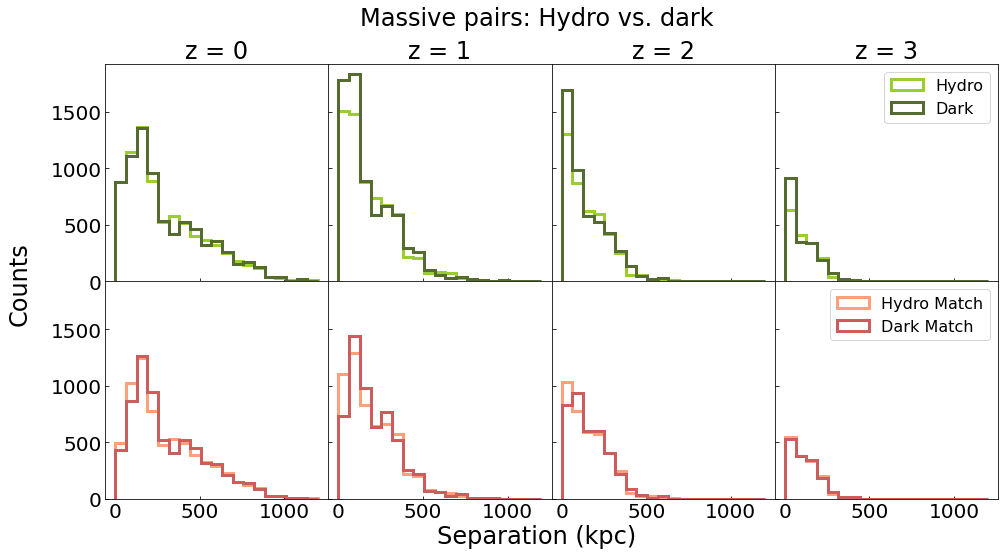

In [110]:
# hydro vs. hydro_matched (all pairs)
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey=True,sharex=False)
plt.subplots_adjust(wspace=0,hspace=0)

for i in range(4):
    dwarf = get_key_snap("hydro", "massive", "Separation", i)
    dwarf_dark = get_key_snap("dark", "massive", "Separation", i)
    
    dwarf_match, dwarf_dark_match = separations_z("massive", i)
    
    dwarf = np.concatenate([dwarf['major'],dwarf['minor']])
    dwarf_match = np.concatenate([dwarf_match['major'],dwarf_match['minor']])
    dwarf_dark = np.concatenate([dwarf_dark['major'],dwarf_dark['minor']])
    dwarf_dark_match = np.concatenate([dwarf_dark_match['major'],dwarf_dark_match['minor']])
        
    bins_d = np.linspace(0,1200,20)
    
    ax[0][i].set_title(f"z = {i}")

    # Illustris Major pairs
    ax[0][i].hist(dwarf, bins=bins_d,histtype="step", color="yellowgreen", lw=3, label='Hydro')
    ax[0][i].hist(dwarf_dark, bins=bins_d,histtype="step", color="darkolivegreen", lw=3, label='Dark')
    
    ax[1][i].hist(dwarf_match, bins=bins_d,histtype="step", color="lightsalmon", lw=3, label='Hydro Match')
    ax[1][i].hist(dwarf_dark_match, bins=bins_d,histtype="step", color="indianred", lw=3, label='Dark Match')
    

for xx in [ax[0][3],ax[1][3]]:
    leg = xx.legend(loc='upper right',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig.supxlabel(r"Separation (kpc)",y=0.04)
fig.supylabel("Counts",x=0.040)
fig.suptitle("Massive pairs: Hydro vs. dark",y=0.98)

plt.savefig(f"../plots/matched/sep_dist_massive_hydrodark.png",bbox_inches='tight',facecolor="white")
plt.show()

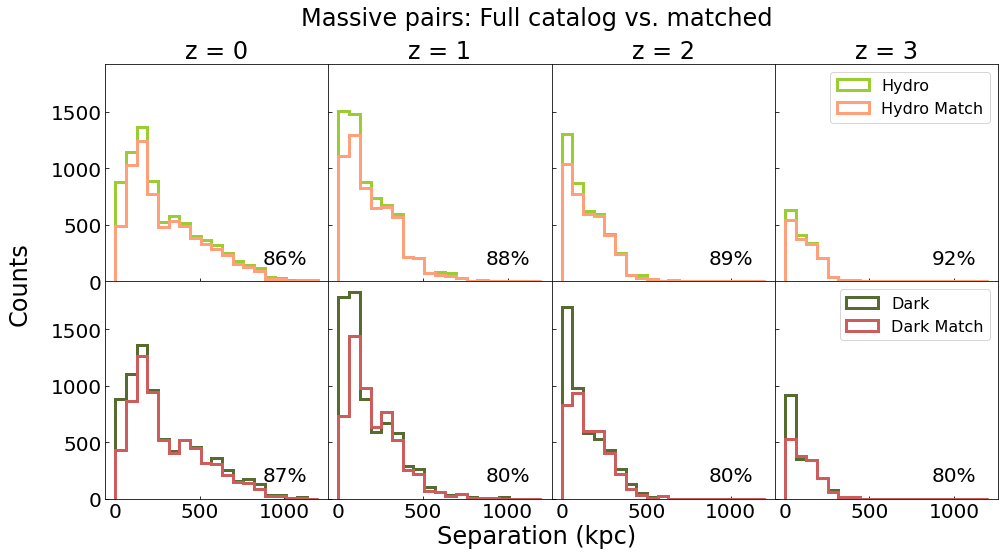

In [111]:
# hydro vs. hydro_matched (all pairs)
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey=True,sharex=False)
plt.subplots_adjust(wspace=0,hspace=0)

hydro_complete = []
dark_complete = []

for i in range(4):
    dwarf = get_key_snap("hydro", "massive", "Separation", i)
    dwarf_dark = get_key_snap("dark", "massive", "Separation", i)
    
    dwarf_match, dwarf_dark_match = separations_z("massive", i)
    
    dwarf = np.concatenate([dwarf['major'],dwarf['minor']])
    dwarf_match = np.concatenate([dwarf_match['major'],dwarf_match['minor']])
    dwarf_dark = np.concatenate([dwarf_dark['major'],dwarf_dark['minor']])
    dwarf_dark_match = np.concatenate([dwarf_dark_match['major'],dwarf_dark_match['minor']])
    
    hydro_complete.append(len(dwarf_match)/len(dwarf))
    dark_complete.append(len(dwarf_dark_match)/len(dwarf_dark))

    bins_d = np.linspace(0,1200,20)
    
    ax[0][i].set_title(f"z = {i}")

    ax[0][i].hist(dwarf, bins=bins_d,histtype="step", color="yellowgreen", lw=3, label='Hydro')
    ax[0][i].hist(dwarf_match, bins=bins_d,histtype="step", color="lightsalmon", lw=3, label='Hydro Match')
    
    ax[1][i].hist(dwarf_dark, bins=bins_d,histtype="step", color="darkolivegreen", lw=3, label='Dark')
    ax[1][i].hist(dwarf_dark_match, bins=bins_d,histtype="step", color="indianred", lw=3, label='Dark Match')
    

for xx in [ax[0][3],ax[1][3]]:
    leg = xx.legend(loc='upper right',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    

xmax = ax[0][0].get_xlim()[1]
ymax = ax[0][0].get_ylim()[1]

for i in range(4):
    ax[0][i].text(0.9*xmax,0.15*ymax,f"{hydro_complete[i]*100:.0f}%",va="top",ha="right")
    ax[1][i].text(0.9*xmax,0.15*ymax,f"{dark_complete[i]*100:.0f}%",va="top",ha="right")

    

fig.supxlabel(r"Separation (kpc)",y=0.04)
fig.supylabel("Counts",x=0.040)
fig.suptitle("Massive pairs: Full catalog vs. matched",y=0.98)

plt.savefig(f"../plots/matched/sep_dist_massive_fullmatch.png",bbox_inches='tight',facecolor="white")
plt.show()

## Velocity distribution

### Comparison - dwarf pairs (all: major + minor)

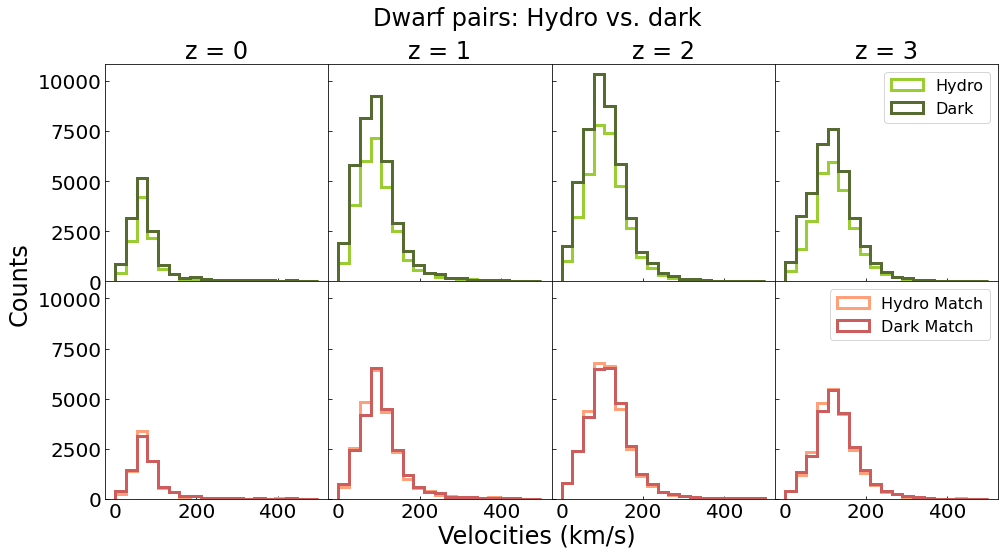

In [115]:
# hydro vs. hydro_matched (all pairs)
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey=True,sharex=False)
plt.subplots_adjust(wspace=0,hspace=0)

for i in range(4):
    dwarf = get_key_snap("hydro", "dwarf", "RelVel", i)
    dwarf_dark = get_key_snap("dark", "dwarf", "RelVel", i)
    
    dwarf_match, dwarf_dark_match = velocities_z("dwarf", i)
    
    dwarf = np.concatenate([dwarf['major'],dwarf['minor']])
    dwarf_match = np.concatenate([dwarf_match['major'],dwarf_match['minor']])
    dwarf_dark = np.concatenate([dwarf_dark['major'],dwarf_dark['minor']])
    dwarf_dark_match = np.concatenate([dwarf_dark_match['major'],dwarf_dark_match['minor']])
        
    bins_d = np.linspace(0,500,20)
    
    ax[0][i].set_title(f"z = {i}")

    # Illustris Major pairs
    ax[0][i].hist(dwarf, bins=bins_d,histtype="step", color="yellowgreen", lw=3, label='Hydro')
    ax[0][i].hist(dwarf_dark, bins=bins_d,histtype="step", color="darkolivegreen", lw=3, label='Dark')
    
    ax[1][i].hist(dwarf_match, bins=bins_d,histtype="step", color="lightsalmon", lw=3, label='Hydro Match')
    ax[1][i].hist(dwarf_dark_match, bins=bins_d,histtype="step", color="indianred", lw=3, label='Dark Match')
    

for xx in [ax[0][3],ax[1][3]]:
    leg = xx.legend(loc='upper right',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig.supxlabel(r"Velocities (km/s)",y=0.04)
fig.supylabel("Counts",x=0.040)
fig.suptitle("Dwarf pairs: Hydro vs. dark",y=0.98)

plt.savefig(f"../plots/matched/vel_dist_dwarf_hydrodark.png",bbox_inches='tight',facecolor="white")
plt.show()

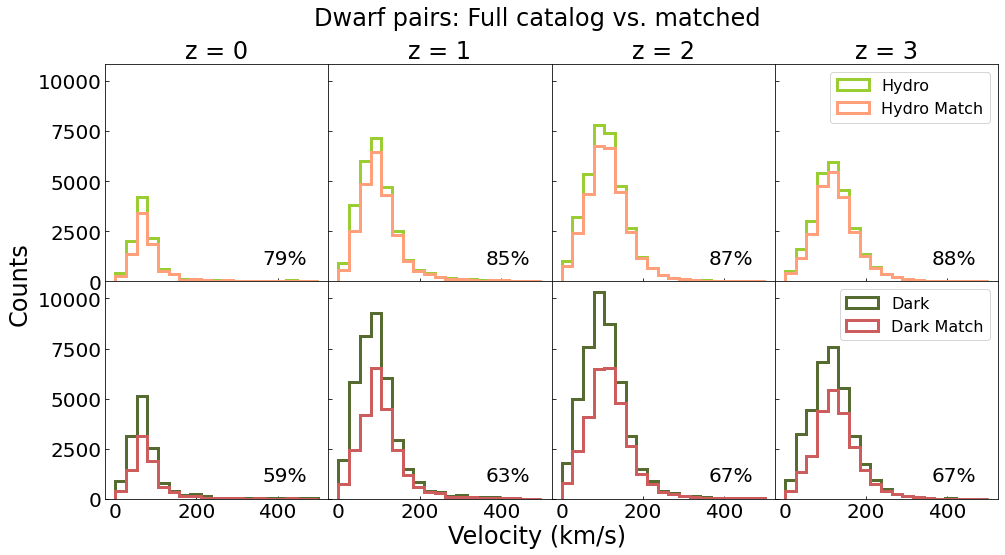

In [117]:
# hydro vs. hydro_matched (all pairs)
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey=True,sharex=False)
plt.subplots_adjust(wspace=0,hspace=0)

hydro_complete = []
dark_complete = []

for i in range(4):
    dwarf = get_key_snap("hydro", "dwarf", "RelVel", i)
    dwarf_dark = get_key_snap("dark", "dwarf", "RelVel", i)
    
    dwarf_match, dwarf_dark_match = velocities_z("dwarf", i)
    
    dwarf = np.concatenate([dwarf['major'],dwarf['minor']])
    dwarf_match = np.concatenate([dwarf_match['major'],dwarf_match['minor']])
    dwarf_dark = np.concatenate([dwarf_dark['major'],dwarf_dark['minor']])
    dwarf_dark_match = np.concatenate([dwarf_dark_match['major'],dwarf_dark_match['minor']])
    
    hydro_complete.append(len(dwarf_match)/len(dwarf))
    dark_complete.append(len(dwarf_dark_match)/len(dwarf_dark))

    bins_d = np.linspace(0,500,20)
    
    ax[0][i].set_title(f"z = {i}")

    ax[0][i].hist(dwarf, bins=bins_d,histtype="step", color="yellowgreen", lw=3, label='Hydro')
    ax[0][i].hist(dwarf_match, bins=bins_d,histtype="step", color="lightsalmon", lw=3, label='Hydro Match')
    
    ax[1][i].hist(dwarf_dark, bins=bins_d,histtype="step", color="darkolivegreen", lw=3, label='Dark')
    ax[1][i].hist(dwarf_dark_match, bins=bins_d,histtype="step", color="indianred", lw=3, label='Dark Match')
    

for xx in [ax[0][3],ax[1][3]]:
    leg = xx.legend(loc='upper right',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    

xmax = ax[0][0].get_xlim()[1]
ymax = ax[0][0].get_ylim()[1]

for i in range(4):
    ax[0][i].text(0.9*xmax,0.15*ymax,f"{hydro_complete[i]*100:.0f}%",va="top",ha="right")
    ax[1][i].text(0.9*xmax,0.15*ymax,f"{dark_complete[i]*100:.0f}%",va="top",ha="right")

    

fig.supxlabel(r"Velocity (km/s)",y=0.04)
fig.supylabel("Counts",x=0.040)
fig.suptitle("Dwarf pairs: Full catalog vs. matched",y=0.98)

plt.savefig(f"../plots/matched/vel_dist_dwarf_fullmatch.png",bbox_inches='tight',facecolor="white")
plt.show()

### Comparison - massive pairs (all: major + minor)

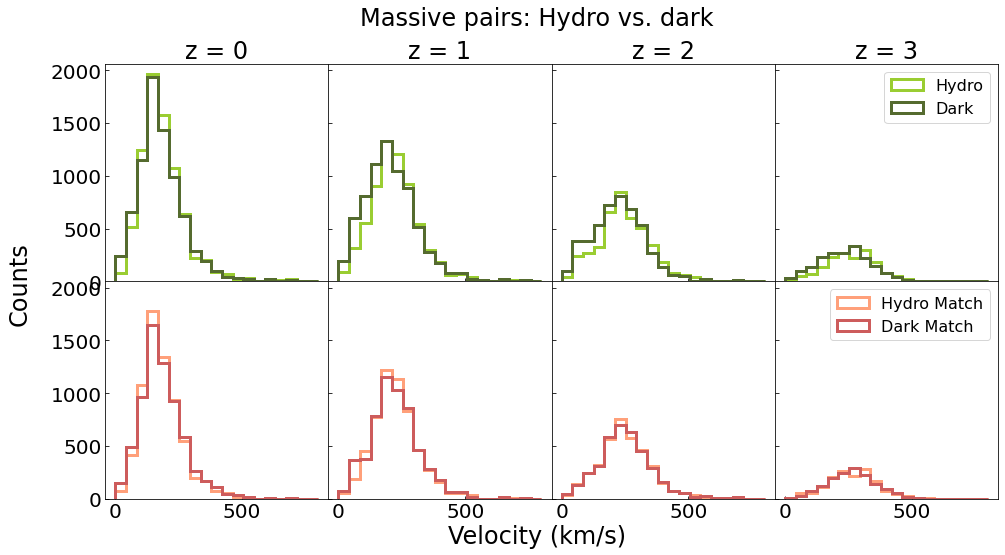

In [124]:
# hydro vs. hydro_matched (all pairs)
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey=True,sharex=False)
plt.subplots_adjust(wspace=0,hspace=0)

for i in range(4):
    dwarf = get_key_snap("hydro", "massive", "RelVel", i)
    dwarf_dark = get_key_snap("dark", "massive", "RelVel", i)
    
    dwarf_match, dwarf_dark_match = velocities_z("massive", i)
    
    dwarf = np.concatenate([dwarf['major'],dwarf['minor']])
    dwarf_match = np.concatenate([dwarf_match['major'],dwarf_match['minor']])
    dwarf_dark = np.concatenate([dwarf_dark['major'],dwarf_dark['minor']])
    dwarf_dark_match = np.concatenate([dwarf_dark_match['major'],dwarf_dark_match['minor']])
        
    bins_d = np.linspace(0,800,20)
    
    ax[0][i].set_title(f"z = {i}")

    # Illustris Major pairs
    ax[0][i].hist(dwarf, bins=bins_d,histtype="step", color="yellowgreen", lw=3, label='Hydro')
    ax[0][i].hist(dwarf_dark, bins=bins_d,histtype="step", color="darkolivegreen", lw=3, label='Dark')
    
    ax[1][i].hist(dwarf_match, bins=bins_d,histtype="step", color="lightsalmon", lw=3, label='Hydro Match')
    ax[1][i].hist(dwarf_dark_match, bins=bins_d,histtype="step", color="indianred", lw=3, label='Dark Match')
    

for xx in [ax[0][3],ax[1][3]]:
    leg = xx.legend(loc='upper right',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig.supxlabel(r"Velocity (km/s)",y=0.04)
fig.supylabel("Counts",x=0.040)
fig.suptitle("Massive pairs: Hydro vs. dark",y=0.98)

plt.savefig(f"../plots/matched/vel_dist_massive_hydrodark.png",bbox_inches='tight',facecolor="white")
plt.show()

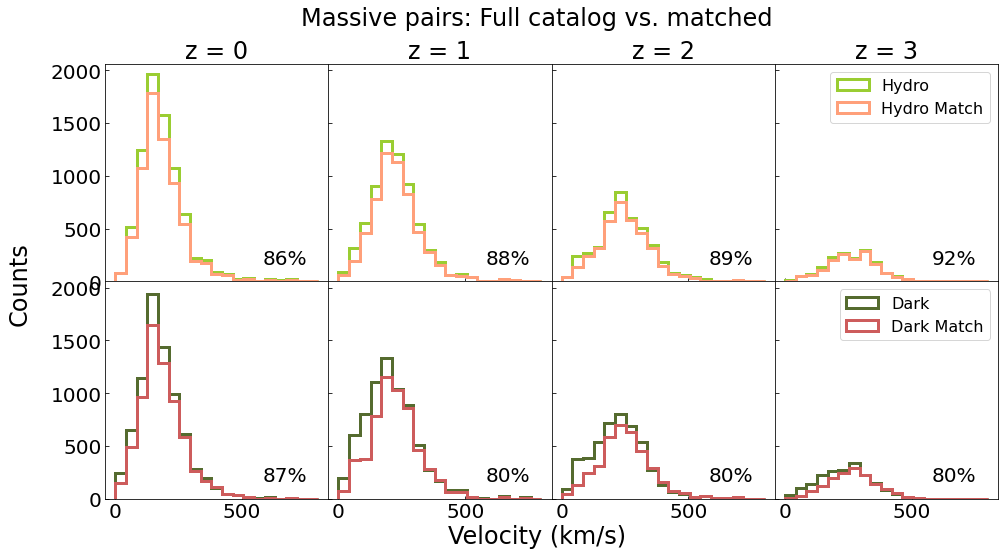

In [123]:
# hydro vs. hydro_matched (all pairs)
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey=True,sharex=False)
plt.subplots_adjust(wspace=0,hspace=0)

hydro_complete = []
dark_complete = []

for i in range(4):
    dwarf = get_key_snap("hydro", "massive", "RelVel", i)
    dwarf_dark = get_key_snap("dark", "massive", "RelVel", i)
    
    dwarf_match, dwarf_dark_match = velocities_z("massive", i)
    
    dwarf = np.concatenate([dwarf['major'],dwarf['minor']])
    dwarf_match = np.concatenate([dwarf_match['major'],dwarf_match['minor']])
    dwarf_dark = np.concatenate([dwarf_dark['major'],dwarf_dark['minor']])
    dwarf_dark_match = np.concatenate([dwarf_dark_match['major'],dwarf_dark_match['minor']])
    
    hydro_complete.append(len(dwarf_match)/len(dwarf))
    dark_complete.append(len(dwarf_dark_match)/len(dwarf_dark))

    bins_d = np.linspace(0,800,20)
    
    ax[0][i].set_title(f"z = {i}")

    ax[0][i].hist(dwarf, bins=bins_d,histtype="step", color="yellowgreen", lw=3, label='Hydro')
    ax[0][i].hist(dwarf_match, bins=bins_d,histtype="step", color="lightsalmon", lw=3, label='Hydro Match')
    
    ax[1][i].hist(dwarf_dark, bins=bins_d,histtype="step", color="darkolivegreen", lw=3, label='Dark')
    ax[1][i].hist(dwarf_dark_match, bins=bins_d,histtype="step", color="indianred", lw=3, label='Dark Match')
    

for xx in [ax[0][3],ax[1][3]]:
    leg = xx.legend(loc='upper right',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    

xmax = ax[0][0].get_xlim()[1]
ymax = ax[0][0].get_ylim()[1]

for i in range(4):
    ax[0][i].text(0.9*xmax,0.15*ymax,f"{hydro_complete[i]*100:.0f}%",va="top",ha="right")
    ax[1][i].text(0.9*xmax,0.15*ymax,f"{dark_complete[i]*100:.0f}%",va="top",ha="right")

    

fig.supxlabel(r"Velocity (km/s)",y=0.04)
fig.supylabel("Counts",x=0.040)
fig.suptitle("Massive pairs: Full catalog vs. matched",y=0.98)

plt.savefig(f"../plots/matched/vel_dist_massive_fullmatch.png",bbox_inches='tight',facecolor="white")
plt.show()

# Scaled distributions

In [126]:
def scaledseps_z(size, z):
    zloc = np.where( zs['z'] == z)[0]
    sim = "TNG"
    snapshot = zs['ztng'][zloc][0] 

    pair_path = f"{sim}_{snapshot}_10_matched.hdf5"
    pair_data = h5py.File(f"{paths.path_data}matched/Vicente/{pair_path}", "r")

    pairs_h = pair_data["paired"]["hydro"]
    pairs_d = pair_data["paired"]["dark match"]

    pri_stell = np.array(pairs_h["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs_h["Sub2 Stellar Mass"])
    seps = np.array(pairs_h["Separation"]) 
    seps_d = np.array(pairs_d["Separation"])
    grrad = np.array(pairs_h["Group Radius"])
    grrad_d = np.array(pairs_d["Group Radius"])
    

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(np.array(pairs_h["Group Mass"]), size)
    
    
    
    
    pair_sepcut = seps > 10
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_group & pair_sepcut

    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors
    
    scaled = seps/

    majors_h = scaled[major_mask]
    minors_h = scaled[minor_mask]

    hydro_dict = {"major":majors_h, "minor":minors_h}
    
    scaled_d = /np.array(pairs_d["Group Radius"])
    
    majors_d = scaled_d[major_mask]
    minors_d = scaled_d[minor_mask]
    
    dark_dict = {"major":majors_d, "minor":minors_d}

    return hydro_dict, dark_dict

def scaledvels_z(size, z):
    
    zloc = np.where( zs['z'] == z)[0]
    sim = "TNG"
    snapshot = zs['ztng'][zloc][0] 


    pair_path = f"{sim}_{snapshot}_10_matched.hdf5"
    pair_data = h5py.File(f"{paths.path_data}matched/Vicente/{pair_path}", "r")

    pairs_h = pair_data["paired"]["hydro"]
    pairs_d = pair_data["paired"]["dark match"]

    pri_stell = np.array(pairs_h["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs_h["Sub2 Stellar Mass"])
    seps = np.array(pairs_h["Separation"]) 
    grmass = np.array(pairs_h["Group Mass"])
    grmass_d = np.array(pairs_d["Group Mass"])
    grrad = np.array(pairs_h["Group Radius"])
    grrad_d = np.array(pairs_d["Group Radius"])

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(grmass, size)
    pair_sepcut = seps > 10
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_group & pair_sepcut

    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors
    
    vels = np.array(pairs_h["RelVel"])             
    vels_d = np.array(pairs_d["RelVel"])
    
    G = 4.3009173e4 # in km^2 kpc / (1e10M⊙ s^2)
    
    vvir = np.sqrt(0.5*G*grmass/grrad)    
    scaled = vels/vvir

    majors_h = scaled[major_mask]
    minors_h = scaled[minor_mask]

    hydro_dict = {"major":majors_h, "minor":minors_h}
    
    vvir_d = np.sqrt(0.5*G*grmass_d/grrad_d)
    scaled_d = vels_d/vvir_d
    
    majors_d = scaled_d[major_mask]
    minors_d = scaled_d[minor_mask]
    
    dark_dict = {"major":majors_d, "minor":minors_d}

    return hydro_dict, dark_dict

def get_key_snap(phys, size, key, z):
    zloc = np.where( zs['z'] == z)[0]
    sim = "TNG"
    snapshot = zs['ztng'][zloc][0] 

    pair_path = f"{sim}_{snapshot}_10.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["pairs"][phys]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    seps = np.array(pairs["Separation"]) 

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(np.array(pairs["Group Mass"]), size)
    pair_sepcut = seps > 10
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_group & pair_sepcut

    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors

    majors = np.array(pairs[key])[major_mask]
    minors = np.array(pairs[key])[minor_mask]

    key_dict = {"major":majors, "minor":minors}
    

    return key_dict

# Redshift evolution

In [92]:
dwarfs = sep_eval("dwarf")
massives = sep_eval("massive")

size = "dwarf"
key = "Separation"
sepcut = None
tngh_d = get_key("TNG", "hydro", size, key, sepcut)

size = "massive"
tngh_m = get_key("TNG", "hydro", size, key, sepcut)

In [85]:
dwarfs

{'z': array([3.70877426e+00, 3.49086137e+00, 3.28303306e+00, 3.00813107e+00,
        2.89578501e+00, 2.73314262e+00, 2.57729027e+00, 2.44422570e+00,
        2.31611074e+00, 2.20792547e+00, 2.10326965e+00, 2.00202814e+00,
        1.90408954e+00, 1.82268925e+00, 1.74357057e+00, 1.66666956e+00,
        1.60423452e+00, 1.53123903e+00, 1.49551217e+00, 1.41409822e+00,
        1.35757667e+00, 1.30237846e+00, 1.24847261e+00, 1.20625808e+00,
        1.15460271e+00, 1.11415056e+00, 1.03551045e+00, 9.97294226e-01,
        9.50531352e-01, 9.23000816e-01, 8.86896938e-01, 8.51470901e-01,
        8.16709979e-01, 7.91068249e-01, 7.57441373e-01, 7.32636182e-01,
        7.00106354e-01, 6.76110411e-01, 6.44641841e-01, 6.21428745e-01,
        5.98543288e-01, 5.75980845e-01, 5.46392183e-01, 5.24565820e-01,
        5.03047523e-01, 4.81832943e-01, 4.60917794e-01, 4.40297849e-01,
        4.19968942e-01, 3.99926965e-01, 3.80167867e-01, 3.60687657e-01,
        3.47853842e-01, 3.28829724e-01, 3.10074120e-01, 2.9

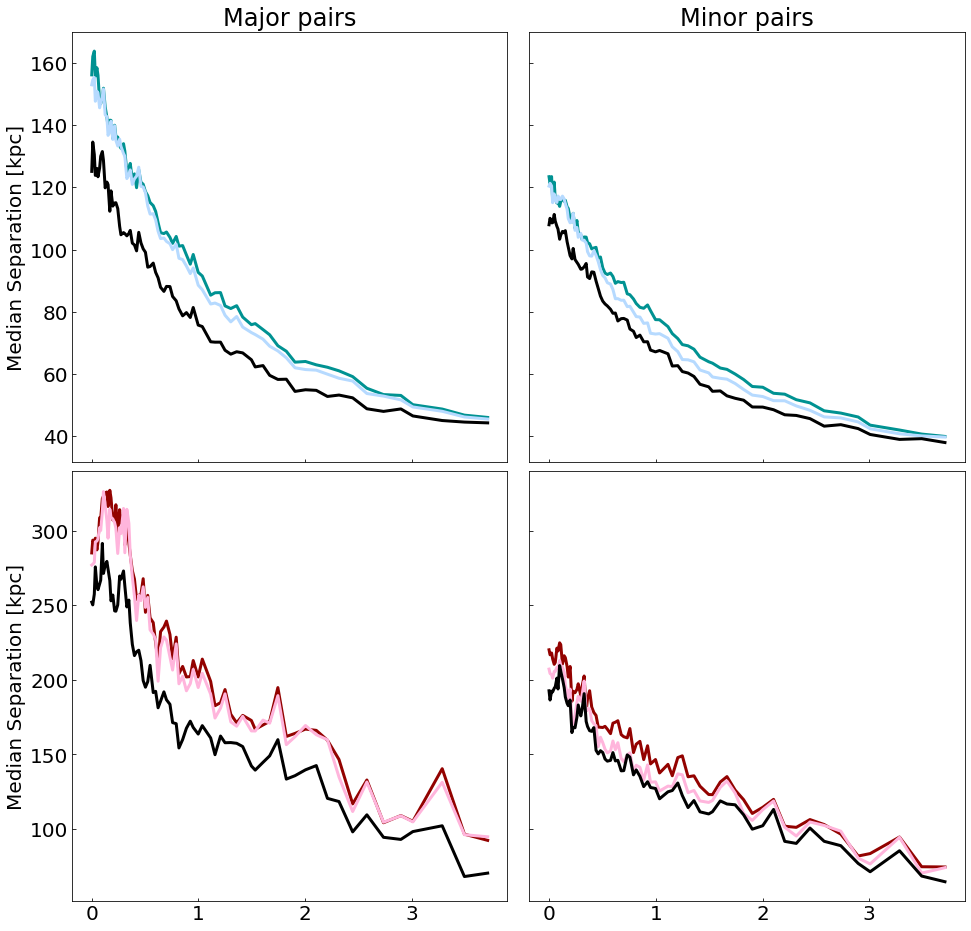

In [96]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,16), sharey="row", sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1,1],'wspace': 0.05,"hspace":0.02})

axmaj_d = ax[0][0]
axmin_d = ax[0][1]
axmaj_m = ax[1][0]
axmin_m = ax[1][1]


axmaj_d.set(title="Major pairs", ylabel="Median Separation [kpc]")
axmin_d.set(title="Minor pairs")
axmaj_m.set(ylabel="Median Separation [kpc]")

al = 0.5

#############
# dwarf major #
#############
axmaj_d.plot(dwarfs['z'],dwarfs['Median D-Major'], color=palette["Illustris dark"], lw=3)
axmaj_d.plot(dwarfs['z'],dwarfs['Median H-Major'], color=palette["Illustris hydro"], lw=3)
axmaj_d.plot(tngh_d['z'],tngh_d['Major Median'], color="black", lw=3)


# axmaj_d.fill_between(dwarfs['z'], np.array(dwarfs['Quarts D-Major'])[:,0], np.array(dwarfs['Quarts D-Major'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark Matched")
# axmaj_d.fill_between(dwarfs['z'], np.array(dwarfs['Quarts H-Major'])[:,0], np.array(dwarfs['Quarts H-Major'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# dwarf minor #
#############
axmin_d.plot(dwarfs['z'],dwarfs['Median D-Minor'], color=palette["Illustris dark"], lw=3)
axmin_d.plot(dwarfs['z'],dwarfs['Median H-Minor'], color=palette["Illustris hydro"], lw=3)
# axmin_d.plot(tngd_d['z'],tngd_d['Minor Median'], color=palette["Illustris dark"], lw=3)
axmin_d.plot(tngh_d['z'],tngh_d['Minor Median'], color="black", lw=3)

# axmin_d.fill_between(tngd_d['z'], np.array(tngd_d['Minor Quarts'])[:,0], np.array(tngd_d['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
# axmin_d.fill_between(tngh_d['z'], np.array(tngh_d['Minor Quarts'])[:,0], np.array(tngh_d['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

#############
# massive major #
#############
axmaj_m.plot(massives['z'],massives['Median D-Major'], color=palette["TNG dark"], lw=3)
axmaj_m.plot(massives['z'],massives['Median H-Major'], color=palette["TNG hydro"], lw=3)
# axmaj_m.plot(tngd_d['z'],tngd_m['Major Median'], color=palette["TNG dark"], lw=3)
axmaj_m.plot(tngh_d['z'],tngh_m['Major Median'], color="black", lw=3)

# axmaj_m.fill_between(tngd_m['z'], np.array(tngd_m['Major Quarts'])[:,0], np.array(tngd_m['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
# axmaj_m.fill_between(tngh_m['z'], np.array(tngh_m['Major Quarts'])[:,0], np.array(tngh_m['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")


#############
# massive minor #
#############
axmin_m.plot(massives['z'],massives['Median D-Minor'], color=palette["TNG dark"], lw=3)
axmin_m.plot(massives['z'],massives['Median H-Minor'], color=palette["TNG hydro"], lw=3)
# axmin_m.plot(tngd_m['z'],tngd_m['Minor Median'], color=palette["TNG dark"], lw=3)
axmin_m.plot(tngh_m['z'],tngh_m['Minor Median'], color="black", lw=3)
# # axmin_m.plot(tngsim_m['z'],tngsim_m['Minor Median'], color='black', lw=3)

# axmin_m.fill_between(tngd_m['z'], np.array(tngd_m['Minor Quarts'])[:,0], np.array(tngd_m['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
# axmin_m.fill_between(tngh_m['z'], np.array(tngh_m['Minor Quarts'])[:,0], np.array(tngh_m['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")


############
############
# for ax, tit in zip([axmin_d,axmin_m],["Dwarf","Massive"]):
#     leg = ax.legend(loc='upper right',title=tit,fontsize=16)

#     for lh in leg.legendHandles: 
#         lh.set_alpha(1)
              
# fig.supxlabel("Redshift",y=0.08)
# plt.savefig(f"../plots/paper1/separations.png",bbox_inches='tight',facecolor="white")
plt.show()


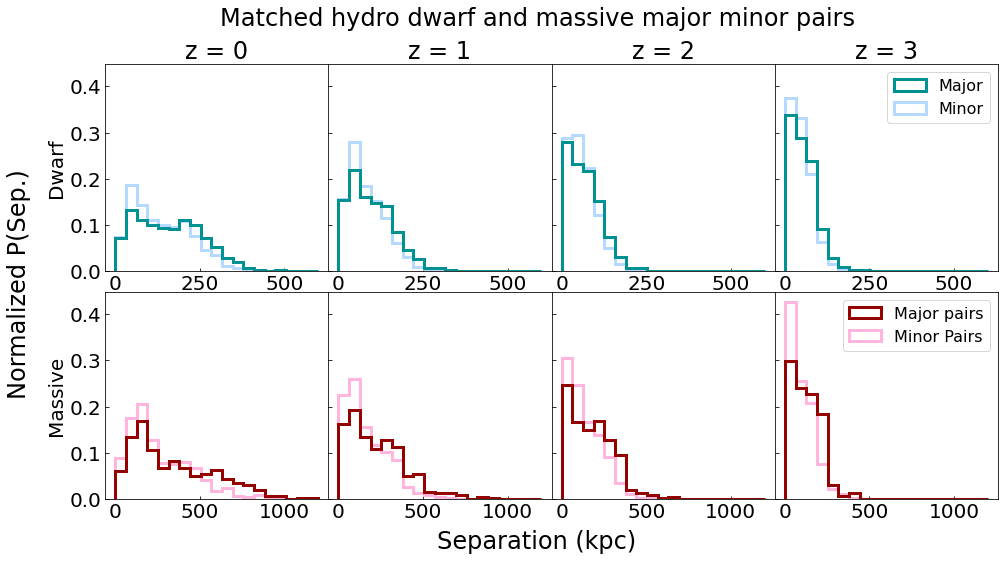

In [59]:
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey=True,sharex=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

for i in range(4):
    tng_d = get_key_snap_match("hydro", "dwarf", "Separation", i)
    tng_m = get_key_snap_match("hydro", "massive", "Separation", i)
    
    bins_d = np.linspace(0,600,20)
    bins_h = np.linspace(0,1200,20)
    
    ax[0][i].set_title(f"z = {i}")

    # Illustris Major pairs
    ax[0][i].hist(tng_d['minor'],bins=bins_d,weights=np.ones(len(tng_d['minor']))/len(tng_d['minor']),histtype="step", color=palette['Illustris hydro'], lw=3) # to put minor behind
    ax[0][i].hist(tng_d['major'],bins=bins_d,weights=np.ones(len(tng_d['major']))/len(tng_d['major']),histtype="step", color=palette['Illustris dark'], lw=3, label='Major')
    ax[0][i].hist(tng_d['minor'],bins=bins_d,weights=np.ones(len(tng_d['minor']))/len(tng_d['minor']),histtype="step", color=palette['Illustris hydro'],alpha=0, lw=3, label='Minor') # to give minor a label

    ax[1][i].hist(tng_m['minor'],bins=bins_h,weights=np.ones(len(tng_m['minor']))/len(tng_m['minor']),histtype="step", color=palette['TNG hydro'], lw=3)# to put minor behind
    ax[1][i].hist(tng_m['major'],bins=bins_h,weights=np.ones(len(tng_m['major']))/len(tng_m['major']),histtype="step", color=palette['TNG dark'], lw=3, label='Major pairs')
    ax[1][i].hist(tng_m['minor'],bins=bins_h,weights=np.ones(len(tng_m['minor']))/len(tng_m['minor']),histtype="step", color=palette['TNG hydro'],alpha=0, lw=3, label='Minor Pairs') # to give minor a label


for xx in [ax[0][3],ax[1][3]]:
    leg = xx.legend(loc='upper right',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig.supxlabel(r"Separation (kpc)",y=0.03)
ax[0][0].set_ylabel("Dwarf")
ax[1][0].set_ylabel("Massive")
fig.supylabel("Normalized P(Sep.)",x=0.040)
fig.suptitle("Matched hydro dwarf and massive major minor pairs")

# plt.savefig(f"../plots/paper1/separations_distributions.png",bbox_inches='tight',facecolor="white")
plt.show()

In [47]:
pair_path = f"TNG_99_10_matched.hdf5"
pair_data = h5py.File(f"{paths.path_data}matched/Vicente/{pair_path}", "r")

In [50]:
pair_data['paired'].keys()

<KeysViewHDF5 ['dark match', 'hydro']>

In [51]:
print(len(pair_data['paired']['hydro']) .keys()

<KeysViewHDF5 ['Comoving Separation', 'Group ID', 'Group Mass', 'Group Nsubs', 'Group Radius', 'Realization', 'RelVel', 'Separation', 'Stellar Mass Ratio', 'Sub1 BHMass', 'Sub1 BHMdot', 'Sub1 GasMetallicity', 'Sub1 ID', 'Sub1 Mass', 'Sub1 MassType', 'Sub1 Pos', 'Sub1 SFR', 'Sub1 SFRinRad', 'Sub1 Stellar Mass', 'Sub1 Vel', 'Sub2 BHMass', 'Sub2 BHMdot', 'Sub2 GasMetallicity', 'Sub2 ID', 'Sub2 Mass', 'Sub2 MassType', 'Sub2 Pos', 'Sub2 SFR', 'Sub2 SFRinRad', 'Sub2 Stellar Mass', 'Sub2 Vel', 'TripleFlag']>